In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)

import os

from copy import deepcopy

import tqdm

from sklearn.datasets import make_spd_matrix

In [2]:
outdir = './output/experiment3'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [3]:
class Theta:
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

In [4]:
from sklearn.mixture import GaussianMixture
import numpy as np


class SDEM(GaussianMixture):
    def __init__(self, r, alpha, n_components=2, **kwargs):
        super().__init__(n_components=n_components, **kwargs)
        
        self.r = r
        self.alpha = alpha
        self.t = 0
        
        self.means_list = []
        self.means_bar_list = []
        self.covariances_list = []
        self.covariances_bar_list = []
        
    def fit(self, X, y=None):
        super().fit(X, y)
        self.means_bar = np.copy(self.means_)
        self.covariances_bar = np.copy(self.covariances_)
        
    def update(self, x):
        """Employ SDEM algorithm."""
        
        # E-step for weights
        gamma = (1-self.alpha*self.r[t]) * self.predict_proba(x.reshape(1, -1)) + self.alpha*self.r[t]/self.weights_.shape[0]
        gamma = gamma.ravel()
        self.weights_ = (1-self.r[t])*self.weights_ + self.r[t]*gamma
        
        x = x.ravel()
        means, means_bar, covariances, covariances_bar = [], [], [], []
        for i, (w, m, cov) in enumerate(zip(self.weights_, self.means_bar, self.covariances_bar)):
            
            # E-step for mean and covariance
            m = (1-self.r[t])*m + self.r[t]*gamma[i]*x
            cov = (1-self.r[t])*cov + self.r[t]*gamma[i]*np.outer(x,x)
            means_bar.append(m)
            covariances_bar.append(cov)

            # M-step for mean and covariance
            m = m/w
            cov = cov/w - np.outer(m, m)
            means.append(m)
            covariances.append(cov)

        
        self.means_ = np.vstack(means)
        self.covariances_ = np.vstack(covariances)
        self.means_bar = np.vstack(means_bar)
        self.covariances_bar = np.vstack(covariances_bar)

        self.means_list.append(self.means_)
        self.covariances_list.append(self.covariances_)
        self.means_bar_list.append(self.means_bar)
        self.covariances_bar_list.append(self.covariances_bar)
        
        self.t += 1

In [5]:
def compute_tau(X, theta):
    N = X.shape[0]
    K = len(theta.pi)

    tau = np.zeros((N, K))
    for k in range(K):
        d_k = norm(theta.mu[k], theta.sigma[k])
        for i in range(N):
            tau[i, k] = theta.pi[k] * d_k.pdf(X[i])
    
    tau /= np.sum(tau, axis=1, keepdims=True)
    
    return tau

In [6]:
def compute_stat(X, Z):
    K = Z.shape[0]
    D = X.shape[1]

    s1 = np.sum(Z, axis=0)
    s2 = X.T.dot(Z).ravel()
    s3 = (X**2).T.dot(Z).ravel()
    
    return s1, s2, s3

In [7]:
def step_M(s, x, eps=1e-8):
    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    mu = s.s2 / (s.s1 + eps)
    sigma = np.sqrt(s.s3 / (s.s1 + eps) - mu**2)
    return pi, mu, sigma

In [8]:
class SuffStat:
    def __init__(self):
        pass

In [9]:
class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.random(K)
        self.s2 = np.random.random(K)
        self.s3 = np.random.random(K)

In [10]:
def sem(X, theta0, rho):
    K = len(theta0.mu)
    N = X.shape[0]
    
    theta_est = np.zeros((N+1, 3*K+1))
    theta_est[1, :] = np.hstack((0, theta0.pi, theta0.mu, theta0.sigma))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(len(theta0.pi), 1)
    
    # initialization
    tau = compute_tau(X[:10, :], theta)
    s.s1, s.s2, s.s3 = compute_stat(X[:10, :], tau)
    
    inds = np.arange(N)
    
    for n in range(11, N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :], theta).ravel()
        s2_indiv_new = X[ind_n, :] * tau_indiv_new
        s3_indiv_new = X[ind_n, :]**2 * tau_indiv_new
                    
        # update the statistics
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
        theta_est[n+1, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
        
    return theta_est

In [11]:
def sra(X, theta0, rho, gamma):
    K = len(theta0.mu)
    N = X.shape[0]
    
    theta_est = np.zeros((N, 3*K+1))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(len(theta0.pi), 1)
    
    # initialization
    tau = compute_tau(X[:10, :], theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[:10, :], tau)
    
    inds = np.arange(N)
    
    for n in range(N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :], theta).ravel()
        s2_indiv_new = X[ind_n, :] * tau_indiv_new
        s3_indiv_new = X[ind_n, :]**2 * tau_indiv_new

        if ( np.any(np.isnan(tau_indiv_new)) | (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) ):
            theta_est[n, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
            continue
            
        # update the statistics
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
                
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, X[ind_n, :])
        theta_est[n, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))

    return theta_est

In [12]:
def generate_data(N, pi, mu, sigma):
    
    z_list = np.random.choice(np.arange(len(pi)), N, replace=True)
    
    X = np.zeros((N, 1))
    for i, z in enumerate(z_list):
        X_i = np.random.normal(mu[z], sigma[z])
        X[i, :] = X_i
    
    return X

In [13]:
N = 10000

In [14]:
Nsim = 1

In [15]:
pi = np.array([0.2, 0.8])
pi0 = pi.copy()

In [16]:
mean1 = 0.5
mu1 = np.array([mean1, -mean1])

mean2 = 1.0
mu2 = np.array([mean2, -mean2])

In [17]:
sigma = np.array([0.1, 0.1])
sigma0 = np.array([0.2, 0.2])

In [18]:
seed0 = 1

In [19]:
mu0 = [0.1, -0.1]

In [20]:
theta = Theta(pi, mu1, sigma)
theta0 = Theta(pi0, mu0, sigma0)

In [21]:
seed = seed0
np.random.seed(seed)
X = np.zeros((2*N, 1))
Xj_former = generate_data(N, pi, mu1, sigma)
X[:N, 0] = Xj_former.ravel()
Xj_latter = generate_data(N, pi, mu2, sigma)
X[N:, 0] = Xj_latter.ravel()

idxes_ol = np.random.choice(np.arange(N), int(0.01*N))
X[idxes_ol, :] = np.random.uniform(-5, 5, len(idxes_ol)).reshape(-1, 1)

## Dependency on alpha 

In [22]:
gamma = 3.0
rho = 0.0116
ratio = 0.1
alpha_orig = 0.01
M = 5
alpha_list = [0.01, 0.05, 0.1]
u = 20
n_trial = 10

mse_eval_alpha =  np.zeros((n_trial, len(alpha_list)))
mse_former_alpha = np.zeros((n_trial, len(alpha_list)))
mse_latter_alpha = np.zeros((n_trial, len(alpha_list)))
mse_overall_alpha =  np.zeros((n_trial, len(alpha_list)))

for trial in tqdm.tqdm(range(n_trial)):
    np.random.seed(trial)
    X = np.zeros((2*N, 1))
    Xj_former = generate_data(N, pi, mu1, sigma)
    X[:N, 0] = Xj_former.ravel()
    Xj_latter = generate_data(N, pi, mu2, sigma)
    X[N:, 0] = Xj_latter.ravel()
    
    for j, alpha in enumerate(alpha_list):
        idxes_ol = np.random.choice(np.arange(2*N), int(alpha*2*N), replace=False)
        X[idxes_ol, :] = np.random.uniform(-u, u, len(idxes_ol)).reshape(-1, 1)

        rho = ratio * (1-alpha_orig)/(1-alpha) *np.exp(-gamma**2/M**2)
        rho_const = np.repeat([rho], X.shape[0])
        theta_est_sra = sra(X, theta0, rho_const, gamma)

        mse_eval = np.sum((theta_est_sra[500:1000, 3:5] - mu1)**2, axis=1)
        mse_eval_alpha[trial, j] = np.mean(mse_eval)
        
        mse_former = np.sum((theta_est_sra[1000:10000, 3:5] - mu1)**2, axis=1)
        mse_former_alpha[trial, j] = np.mean(mse_former)
        
        mse_latter = np.sum((theta_est_sra[10000:, 3:5] - mu2)**2, axis=1)
        mse_latter_alpha[trial, j] = np.mean(mse_latter)

        mse_overall = np.hstack((mse_former, mse_latter))
        mse_overall_alpha[trial, j] = np.mean(mse_overall)

        print(np.mean(mse_eval), np.mean(mse_former), np.mean(mse_latter), np.mean(mse_overall))

  0%|          | 0/10 [00:00<?, ?it/s]/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.0021014678704488984 0.0024049441945100955 0.001977626655594734 0.0021800402266599055
0.0037351928475942266 0.007617017596990774 0.1474191127166607 0.08119706765997493


 10%|█         | 1/10 [01:52<16:52, 112.49s/it]

0.015944313751274013 0.014559992578456556 0.0073454431443337655 0.0107628612973393
0.0027828433603861945 0.0018379621222346211 0.0021207383218861 0.0019867917009985573
0.006326138154849464 0.0060009474489323795 0.004369323892663926 0.005142198208791088


 20%|██        | 2/10 [03:43<14:57, 112.15s/it]

0.012195422031230236 0.012033868348255504 0.015955423537026572 0.014097844763398173
0.0014123332761470627 0.001671735690172463 0.0020298678961288025 0.001860226324886326
0.0029853958819001593 0.007123537298849829 0.0044354254519208165 0.0057087415899398225


 30%|███       | 3/10 [05:42<13:18, 114.11s/it]

0.0128441895129767 0.011654651564770798 0.007877752291665378 0.009666809842083736
0.0020706076811293894 0.00208497607553327 0.021873114904892677 0.01249978598572243
0.002322682069984328 0.007467447861879079 0.046088828913180606 0.02779449052045883


 40%|████      | 4/10 [07:35<11:22, 113.70s/it]

0.007866869406835892 0.013058438260500075 0.03441129472013395 0.024296783765570533
0.002330023609156684 0.0017571541488169275 0.026632256380925725 0.014849313218347877
0.003517924375631876 0.00446327498382807 0.029041382816959897 0.01739912121179219


 50%|█████     | 5/10 [09:31<09:32, 114.47s/it]

0.014768283992623381 0.011727761848507068 0.717299408337969 0.38308126000085546
0.0020292456352065465 0.0027479503640732597 0.0021517168362636552 0.0024341432441734676
0.0038861648976974265 0.008605015157426897 0.0044275691888244284 0.006406359384478228


 60%|██████    | 6/10 [11:29<07:42, 115.54s/it]

0.01371200859256011 0.017774243104683493 0.007183124406605695 0.012199970105695178
0.001135221319158567 0.0022398797097421246 0.0024200034643247405 0.0023346816858382377
0.0021734610840270716 0.00867252819320332 0.21647742380021265 0.11804352588110298


 70%|███████   | 7/10 [13:29<05:50, 116.71s/it]

0.008154894862514042 0.015945454960452812 0.013103052035710962 0.014449453421114996
0.001589899391728482 0.001944687929468963 0.0022371398609707656 0.0020986099986804382
0.003768008628888501 0.004227680710075858 0.004992971734886595 0.004630465459976246


 80%|████████  | 8/10 [15:25<03:53, 116.75s/it]

0.011143417228330761 0.012397823463835183 0.25025461728976306 0.1375856096880077
nan nan nan nan
nan nan nan nan


 90%|█████████ | 9/10 [17:05<01:51, 111.72s/it]

nan nan nan nan
0.002306593082290716 0.002096051863714809 0.002213868933919168 0.002158060848032893
0.002426232092928858 0.008961644709108306 0.0047389187784530155 0.0067391573771844685


100%|██████████| 10/10 [19:02<00:00, 114.28s/it]

0.010913768698788878 0.014197858345640597 0.008192886074239042 0.011037346623850303


In [23]:
mse_eval_alpha.shape

(10, 3)

In [24]:
mse_eval_alpha_df = pd.DataFrame(mse_eval_alpha[:, ::-1], columns=['0.9', '0.95', '0.99'])

In [25]:
mse_eval_alpha_df_melt = mse_eval_alpha_df.melt()

In [26]:
mse_former_alpha_df = pd.DataFrame(mse_former_alpha[:, ::-1], columns=['0.9', '0.95', '0.99'])

In [27]:
mse_former_alpha_df_melt = mse_former_alpha_df.melt()

In [28]:
mse_latter_alpha_df = pd.DataFrame(mse_latter_alpha[:, ::-1], columns=['0.9', '0.95', '0.99'])

In [29]:
mse_latter_alpha_df_melt = mse_latter_alpha_df.melt()

In [30]:
mse_overall_alpha_df = pd.DataFrame(mse_overall_alpha[:, ::-1], columns=['0.9', '0.95', '0.99'])

In [31]:
mse_overall_alpha_df_melt = mse_overall_alpha_df.melt()

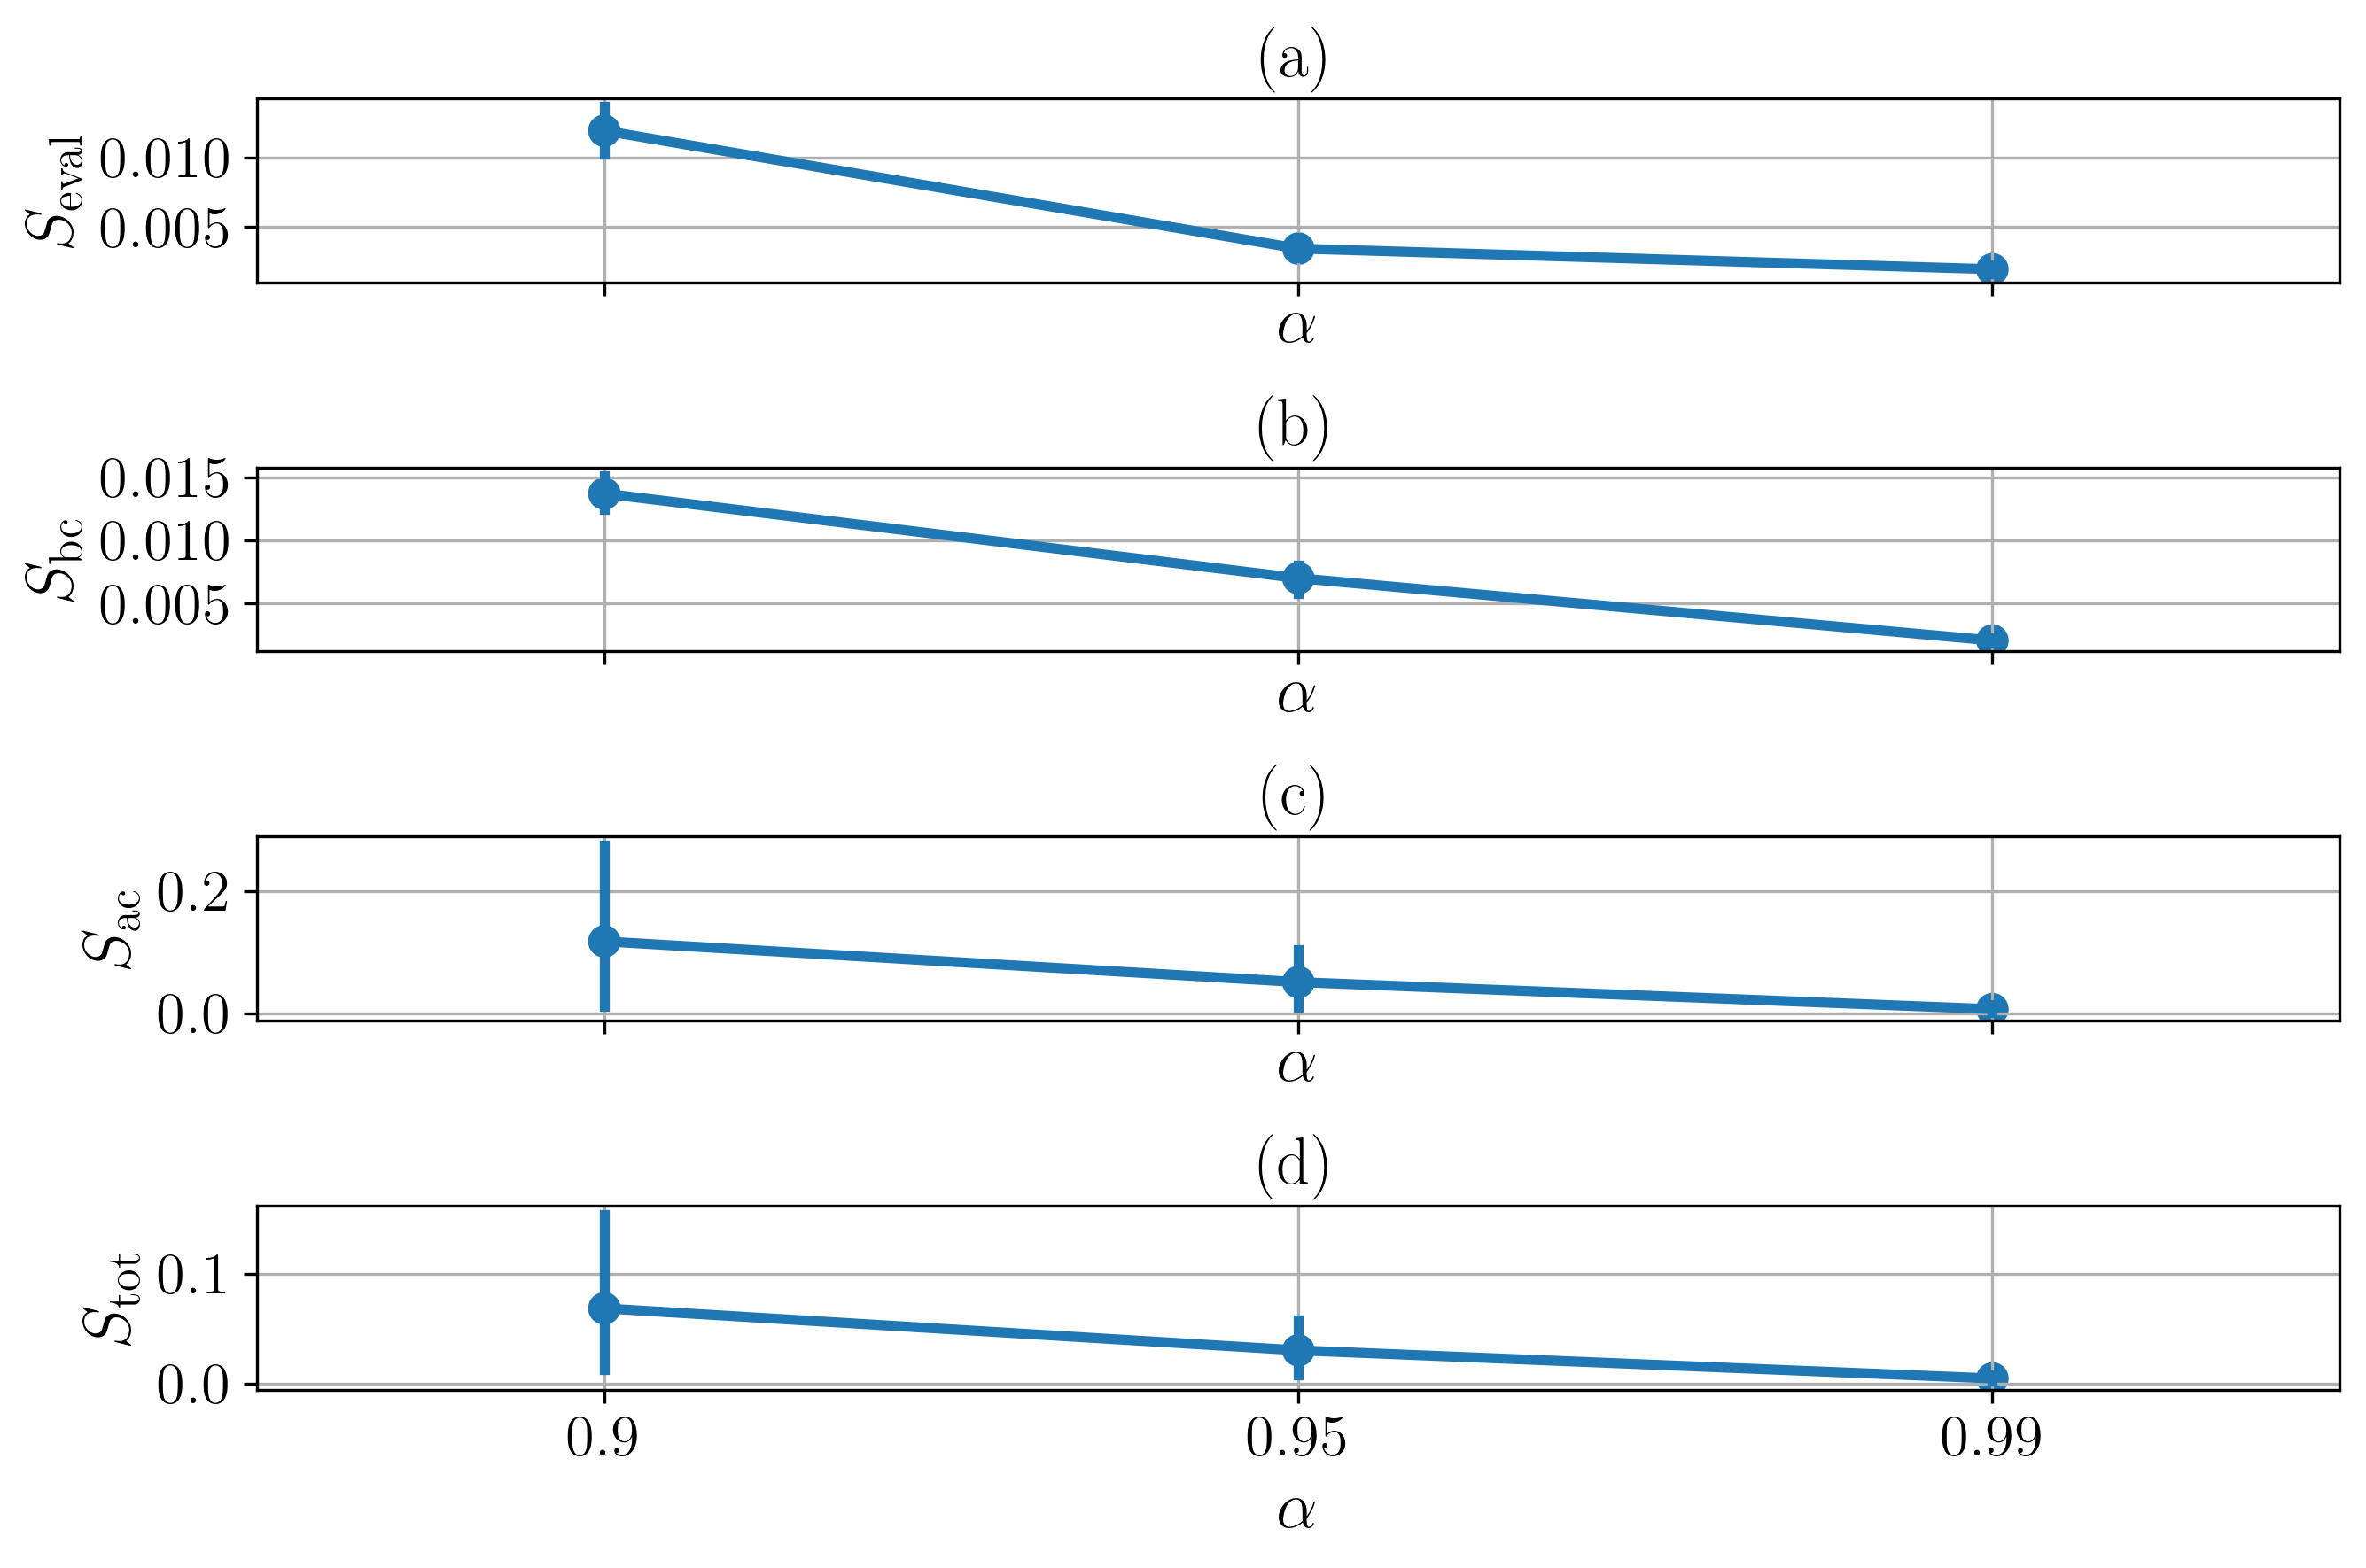

In [32]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(9, 6), dpi=300)
sns.pointplot(data=mse_eval_alpha_df_melt, x='variable', y='value', ax=axes[0])
sns.pointplot(data=mse_former_alpha_df_melt, x='variable', y='value', ax=axes[1])
sns.pointplot(data=mse_latter_alpha_df_melt, x='variable', y='value', ax=axes[2])
sns.pointplot(data=mse_overall_alpha_df_melt, x='variable', y='value', ax=axes[3])

axes[0].grid()
axes[0].set_title('(a)', fontsize=18)
axes[0].set_xlabel(r'$\alpha$', fontsize=18)
axes[0].set_ylabel(r'$S_{\mathrm{eval}}$', fontsize=18)

axes[1].grid()
axes[1].set_title('(b)', fontsize=18)
axes[1].set_xlabel(r'$\alpha$', fontsize=18)
axes[1].set_ylabel(r'$S_{\mathrm{bc}}$', fontsize=18)

axes[2].grid()
axes[2].set_title('(c)', fontsize=18)
axes[2].set_xlabel(r'$\alpha$', fontsize=18)
axes[2].set_ylabel(r'$S_{\mathrm{ac}}$', fontsize=18)

axes[3].grid()
axes[3].set_title('(d)', fontsize=18)
axes[3].set_xlabel(r'$\alpha$', fontsize=18)
axes[3].set_ylabel(r'$S_{\mathrm{tot}}$', fontsize=18)

plt.rc('font', family='serif')
axes[3].set_xticklabels([0.9, 0.95, 0.99])

for ax in axes:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'dependency_on_alpha.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'dependency_on_alpha.eps'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'dependency_on_alpha.png'), bbox_inches='tight')